In [3]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV, cross_validate, cross_val_score, train_test_split, ShuffleSplit, GridSearchCV, KFold, StratifiedKFold, RepeatedStratifiedKFold
%matplotlib inline
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler, PolynomialFeatures
from sklearn.feature_selection import RFE, RFECV
from sklearn.svm import SVC
from scipy.stats import skew, boxcox_normmax
from scipy.special import boxcox1p
from sklearn.decomposition import PCA
from scipy.stats import skew
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_predict

In [4]:
data=pd.read_csv('C:/Users/vratu/OneDrive/Desktop/MBD/MBD_Term_2/Machine Learning 2/Group Assignment/Training_Set_Values_joined_prepared1.csv')

In [5]:
#data.describe().T

In [6]:
#data.info()

## Feature preparation (after cleaning on Dataiku)

In [7]:
def fix_types_category(df):
    df['date_recorded_year'] = df['date_recorded_year'].astype('uint8')
    df['funder'] = df['funder'].astype('category')
    df['installer'] = df['installer'].astype('category')
    df['basin'] = df['basin'].astype('category')
    df['region'] = df['region'].astype('category')
    df['region-dist'] = df['region-dist'].astype('category')
    df['scheme_management'] = df['scheme_management'].astype('category')
    df['extraction_type_class'] = df['extraction_type_class'].astype('category')
    df['management_group'] = df['management_group'].astype('category')
    df['payment'] = df['payment'].astype('category')
    df['quality_group'] = df['quality_group'].astype('category')
    df['quantity'] = df['quantity'].astype('category')
    df['source_type'] = df['source_type'].astype('category')
    df['source_class'] = df['source_class'].astype('category')
    df['waterpoint_type_group'] = df['waterpoint_type_group'].astype('category')
    df['status_group'] = df['status_group'].astype('category')
    return df

In [8]:
def scale(df):
    scaler = MinMaxScaler()
    for i in ('population', 'amount_tsh', 'longitude', 'latitude', 'gps_height', 'distance_from_water', 'date_recorded_year'):
        df[[i]] = scaler.fit_transform(df[[i]])
    return df

In [9]:
def feature_skewness(df): 
    df = df.drop(['latitude', 'longitude'], axis=1)
    numeric_dtypes = ['int16', 'int32', 'int64', 
                      'float16', 'float32', 'float64', 'uint8']
    numeric_features = []
    for i in df.columns:
        if df[i].dtype in numeric_dtypes: 
            numeric_features.append(i)

    feature_skew = df[numeric_features].apply(lambda x: skew(x)).sort_values(ascending=False)
    skews = pd.DataFrame({'skew':feature_skew})
    return feature_skew, numeric_features

def fix_skewness(df):
    feature_skew, numeric_features = feature_skewness(df)
    high_skew = feature_skew[feature_skew > 0.5]
    skew_index = high_skew.index
    
    for i in skew_index:
        df[i] = boxcox1p(df[i], boxcox_normmax(df[i]+1))

    skew_features = df[numeric_features].apply(lambda x: skew(x)).sort_values(ascending=False)
    skews = pd.DataFrame({'skew':skew_features})
    return df

In [10]:
def numerical_features(df):
    columns = df.columns
    return df._get_numeric_data().columns

def categorical_features(df):
    numerical_columns = numerical_features(df)
    return(list(set(df.columns) - set(numerical_columns)))

def onehot_encode(df):
    df1 = df.drop(['status_group'], axis=1)
    numericals = df1.get(numerical_features(df1))
    new_df = numericals.copy()
    for categorical_column in categorical_features(df1):
        new_df = pd.concat([new_df, 
                            pd.get_dummies(df1[categorical_column], 
                                           prefix=categorical_column)], 
                           axis=1)
    new_df['status_group'] = df['status_group']
    return new_df

In [11]:
def data_preparation(df):
    temp = df.drop(['id', 'months_since_recorded', 'date_recorded_day', 'date_recorded_month', 'construction_year'], axis=1)
    aux = fix_types_category(temp)
    aux2 = scale(aux)
    aux3 = fix_skewness(aux2)
    aux4 = scale(aux3)
    final = onehot_encode(aux4)
    return final

In [12]:
dataset = data_preparation(data)
dataset.head()

C:\Users\vratu\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\vratu\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\vratu\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,amount_tsh,date_recorded_year,gvt_funder,gps_height,installer_gvt,longitude,latitude,population,public_meeting,permit,...,source_type_shallow well,source_type_spring,extraction_type_class_gravity,extraction_type_class_handpump,extraction_type_class_motorpump,extraction_type_class_other,extraction_type_class_rope pump,extraction_type_class_submersible,extraction_type_class_wind-powered,status_group
0,1.000000,0.818182,False,0.517483,False,0.865979,0.153923,0.338240,True,False,...,0,1,1,0,0,0,0,0,0,functional
1,0.000000,1.000000,False,0.520629,False,0.860047,0.815659,0.652706,False,True,...,0,0,1,0,0,0,0,0,0,functional
2,0.578332,1.000000,False,0.271329,False,0.928504,0.671973,0.611216,True,True,...,0,0,1,0,0,0,0,0,0,functional
3,0.000000,1.000000,False,0.123427,False,0.953922,0.042418,0.197374,True,True,...,0,0,0,0,0,0,0,1,0,non functional
4,0.000000,0.818182,False,0.031469,False,0.771612,0.843309,0.000000,True,True,...,0,0,1,0,0,0,0,0,0,functional


In [13]:
# dataset.describe().T

#### Basic functions defined

In [14]:
def target_encoding(y_train):
    le=LabelEncoder()
    le.fit(y_train)
    print(le.classes_)
    y_encoded=le.transform(y_train)
    return y_encoded

def target_decoding(y_encoded):
    le=LabelEncoder()
    le.fit(dataset['status_group'])
    print(le.classes_)
    y_back = le.inverse_transform(y_encoded)
    return y_back 

In [15]:
def data_split(df, seed=666):
    X = df.loc[:, df.columns != 'status_group']
    y = df.loc[:, 'status_group']
    y_encoded = target_encoding(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.40, random_state=seed)
    return X_train, X_test, y_train, y_test

### Base-line model prior to feature selection

In [16]:
def model_accuracy(df, seed=666):
    X = df.loc[:, df.columns != 'status_group']
    y = df.loc[:, 'status_group']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed)

    #Logistic Regression Model
    logreg = LogisticRegression(class_weight = 'balanced', penalty = 'l1')
    logreg.fit(X_train,y_train)
    pred=logreg.predict(X_test)
    
    accuracy = accuracy_score(y_test, pred)    
    return accuracy

acc = model_accuracy(dataset)
print(round(acc,4))

C:\Users\vratu\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vratu\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.7153


# Feature Selection

### RFE

['functional' 'functional needs repair' 'non functional']


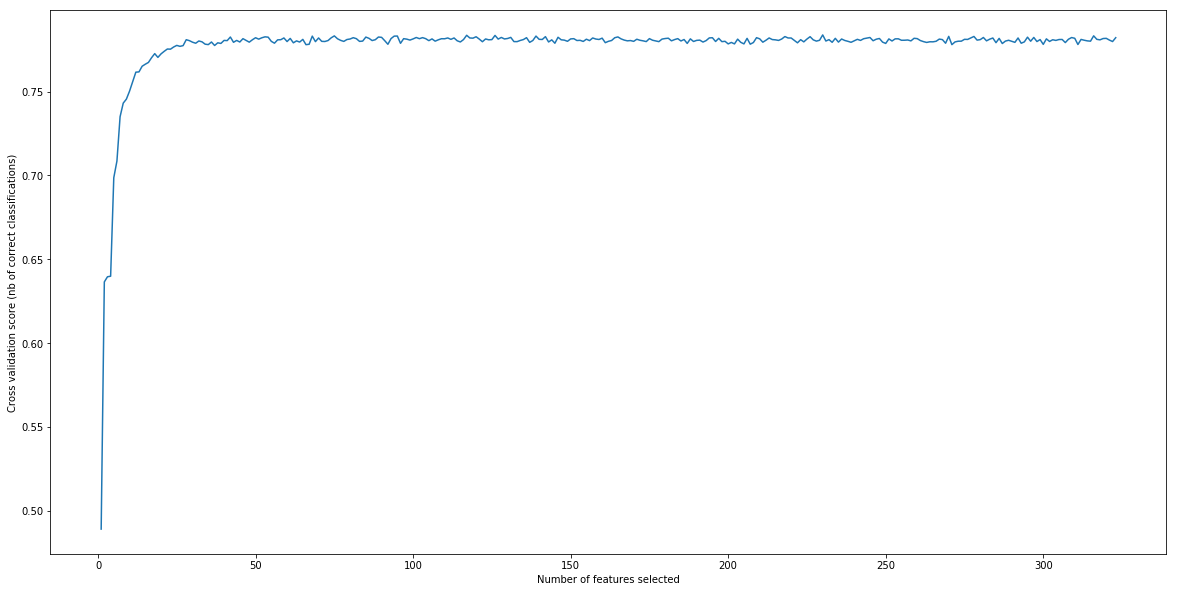

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Columns: 231 entries, amount_tsh to status_group
dtypes: bool(4), category(1), float64(7), uint8(219)
memory usage: 15.9 MB


In [17]:
X_train, X_test, y_train, y_test = data_split(dataset) 

RFE_estimator = RandomForestClassifier(n_estimators=10, class_weight='balanced') # Alternatively, Naive Bayes was used as estimator (MultinomialNB()) which returned 302 features as important features
rfecv = RFECV(estimator=RFE_estimator, step=1, cv=5, scoring='accuracy') # try with shuffle =True once
rfecv.fit(X_train, y_train)

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(20,10))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

d={'scores':rfecv.grid_scores_, 'n_feats':range(1, len(rfecv.grid_scores_)+1)}
rfescores = pd.DataFrame(data=d)
rfescores[rfescores['scores']==rfescores['scores'].max()]
feats_bestcv=int(rfescores[rfescores['scores']==rfescores['scores'].max()]['n_feats'])
feats_bestcv
#rfescores[rfescores['scores']==rfescores['scores'].max()]['n_feats']

featuresnames=np.array(dataset.columns.drop('status_group'))
featuresnames_RFE=featuresnames[np.array(rfecv.support_)]
featuresnames_RFE= np.append(featuresnames_RFE, 'status_group')
features_RFE=dataset[featuresnames_RFE]

features_RFE.info()

In [18]:
feats_bestcv

230

In [19]:
#features_RFE.columns

In [20]:
#features_RFE = pd.read_csv('C:/Users/vratu/OneDrive/Desktop/MBD/MBD_Term_2/Machine Learning 2/Group Assignment/Training_Set_RFE_FEATURES.csv')

### Base-line model post feature selection

In [21]:
acc_RFE = model_accuracy(features_RFE)
print(round(acc_RFE,4))

C:\Users\vratu\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vratu\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.7125


Although there is minimal decrease in accuracy scores due to elimindated features - we have proceeded with RFE features since the we aim to optimize through models other than Logistic Regression, which would be better without noise.

### PCA (Dimensionality Reduction) 

###### Discarded because only 1 PC was created which explained >99% of variance, hence not feasible for classification purposes (accuracy score of 0.5141 on base-line model)

## Bayesian optimization method for creating 4 primary models

In [22]:
X_train, X_test, y_train, y_test = data_split(features_RFE)

['functional' 'functional needs repair' 'non functional']


### Model 1 - Random Forest Classifier

In [23]:
model_RFC_opt = RandomForestClassifier(n_estimators=115, min_samples_split=16, max_features=0.2722)

In [24]:
X_train, X_test, y_train, y_test = data_split(features_RFE)
model_RFC_opt.fit(X_train, y_train)

['functional' 'functional needs repair' 'non functional']


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.2722, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=16,
            min_weight_fraction_leaf=0.0, n_estimators=115, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [25]:
y_pred_RFC = model_RFC_opt.predict(X_test)

In [26]:
score_RFC = accuracy_score(y_test, y_pred_RFC)
score_RFC

0.8027777777777778

### Model 2 - KNearestNeighbours model

In [27]:
model_KNN_opt = KNeighborsClassifier(algorithm='kd_tree', weights='distance', n_jobs=-1, n_neighbors=15, leaf_size=29, p=1)

In [28]:
model_KNN_opt.fit(X_train, y_train)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=29, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=15, p=1,
           weights='distance')

In [29]:
y_pred_KNN = model_KNN_opt.predict(X_test)

In [30]:
y_pred_KNN_cat = target_decoding(y_pred_KNN)
y_pred_KNN_cat

['functional' 'functional needs repair' 'non functional']


array(['functional', 'non functional', 'functional', ...,
       'non functional', 'non functional', 'functional'], dtype=object)

In [31]:
score_KNN = accuracy_score(y_test, y_pred_KNN)
score_KNN

0.7762626262626262

### Model 3 - XGBoost Trees

In [32]:
model_XGB_opt = XGBClassifier(booster = 'gbtree', objective = 'multi:softprob', eval_metric = "mlogloss",
                              learning_rate=0.5958, gamma=0.6221, max_depth=16, 
                              min_child_weight=1.127, max_delta_step=8, subsample=0.9791, 
                              colsample_bytree=0.5958, reg_lambda=1.302, 
                              reg_alpha=0.2765, importance_type = 'total_cover', n_jobs=-1, silent=True)

In [33]:
model_XGB_opt.fit(X_train, y_train)
y_pred_xgb = model_XGB_opt.predict(X_test)
scores_xgb = accuracy_score(y_test, y_pred_xgb)
scores_xgb

0.7968855218855219

### Model 4 - Multi-nomial Naive Bayes Model

In [34]:
model_MNB_opt = MultinomialNB(alpha=25.71)

In [35]:
model_MNB_opt.fit(X_train, y_train)
y_pred_MNB = model_MNB_opt.predict(X_test)
accuracy_score(y_test, y_pred_MNB)

0.6871632996632997

## Optimized Stacked Model - Random Forest Classifier

This optimization code was run basis the stacked_df which is created at end of stacking pipeline. However, for sake of readability (and flow) this code appears here 

In [36]:
# create optimized RFC basis the parameters found above (refer images attached in zip file)

stacked_RFC = RandomForestClassifier(class_weight='balanced', max_features=0.1412, 
                                     min_samples_split=25, n_estimators=180, n_jobs=-1)

## Other models (WIP)

### LDA

In [37]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

In [38]:
model_LDA = LinearDiscriminantAnalysis(solver='svd', n_components=145)
X_train, X_test, y_train, y_test = data_split(features_RFE)

['functional' 'functional needs repair' 'non functional']


In [39]:
model_LDA.fit(X_train, y_train)
y_pred_LDA = model_LDA.predict(X_test)

C:\Users\vratu\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [40]:
scores_LDA= accuracy_score(y_test, y_pred_LDA, normalize=True)
scores_LDA.mean()

0.7296296296296296

# Final Stacking and Pipeline

In [41]:
def stacked_model_fits(df):
    X = df.loc[:, df.columns != 'status_group']
    y1 = df.loc[:, 'status_group']
    y=target_encoding(y1)
    model_RFC_opt.fit(X, y)
    model_XGB_opt.fit(X, y)
    model_MNB_opt.fit(X, y)
    model_KNN_opt.fit(X, y)

def stacked_1_predict(X, y):
    y_pred_RFC = cross_val_predict(model_RFC_opt, X, y, cv=5)
    y_pred_XGB = cross_val_predict(model_XGB_opt, X, y, cv=5)
    y_pred_MNB = cross_val_predict(model_MNB_opt, X, y, cv=5)
    y_pred_KNN = cross_val_predict(model_KNN_opt, X, y, cv=5)
    
    RFC_pred = pd.Series(y_pred_RFC.flatten(), name='rfc')
    XGB_pred = pd.Series(y_pred_XGB.flatten(), name='xgb')
    MNB_pred = pd.Series(y_pred_MNB.flatten(), name='mnb')
    KNN_pred = pd.Series(y_pred_KNN.flatten(), name='knn')
    y_target = pd.Series(y, name='y_target')
    stack_features_final = pd.concat([X['longitude'], X['latitude'], RFC_pred, XGB_pred, MNB_pred, KNN_pred, y_target], axis=1)
    return stack_features_final

def stacked_2_predict(X):
    y_pred_RFC2 = model_RFC_opt.predict(X)
    y_pred_XGB2 = model_XGB_opt.predict(X)
    y_pred_MNB2 = model_MNB_opt.predict(X)
    y_pred_KNN2 = model_KNN_opt.predict(X)
    
    RFC_pred2 = pd.Series(y_pred_RFC2.flatten(), name='rfc')
    XGB_pred2 = pd.Series(y_pred_XGB2.flatten(), name='xgb')
    MNB_pred2 = pd.Series(y_pred_MNB2.flatten(), name='mnb')
    KNN_pred2 = pd.Series(y_pred_KNN2.flatten(), name='knn')
    stack_features_final = pd.concat([X['longitude'], X['latitude'], RFC_pred2, XGB_pred2, MNB_pred2, KNN_pred2], axis=1)
    return stack_features_final

def stacked_model_predict(df):
    stacked_model=make_pipeline(PolynomialFeatures(2), stacked_RFC)
    
    stacked_model_fits(df)
    
    X = df.loc[:, df.columns != 'status_group']
    y1 = df.loc[:, 'status_group']
    y=target_encoding(y1)
    df_stacked = stacked_1_predict(X, y)
    
    X2 = df_stacked.loc[:, df_stacked.columns != 'y_target']
    y2 = df_stacked.loc[:, 'y_target']
    X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.20, random_state=123)
    
    stacked_model.fit(X2_train, y2_train)
    y_pred_stacked = stacked_model.predict(X2_test)
    scores_stacked = accuracy_score(y2_test, y_pred_stacked)
    return stacked_model, scores_stacked

def stacked_model_final_upload(stacked_model, df_test_prepared):
    stacked_test = stacked_2_predict(df_test_prepared) 
    prediction = stacked_model.predict(stacked_test)
    prediction_cat = pd.Series(target_decoding(prediction))
    prediction_cat.to_csv('C:\\Users\\vratu\\OneDrive\\Desktop\\MBD\\MBD_Term_2\\Machine Learning 2\\Group Assignment\\Upload_predictions.csv')
    #return prediction

## Fit the primary models with entire training set

In [42]:
stacked_model_fits(features_RFE)

['functional' 'functional needs repair' 'non functional']


## Fit the stacked RFC model

In [43]:
stacked_RFC_model_fitted, scores = stacked_model_predict(features_RFE)  

['functional' 'functional needs repair' 'non functional']
['functional' 'functional needs repair' 'non functional']


In [44]:
scores # test and validate the stacked RFC model

0.7758417508417509

##### Export CSV for later use

In [45]:
X = features_RFE.loc[:, features_RFE.columns != 'status_group']
y1 = features_RFE.loc[:, 'status_group']
y = target_encoding(y1)
stacked_df = stacked_1_predict(X, y)

['functional' 'functional needs repair' 'non functional']


In [47]:
#stacked_df.to_csv('...\stacked_df.csv')

## Import and predict on the test Data-set (for upload)

### Data preperation

In [48]:
df_test_raw = pd.read_csv('C:\\Users\\vratu\\OneDrive\\Desktop\\MBD\\MBD_Term_2\\Machine Learning 2\\Group Assignment\\Test_set_values_joined_prepared.csv')

In [49]:
#df_test_raw.describe().T

In [50]:
data_test = df_test_raw.drop(['id', 'months_since_recorded', 'date_recorded_day', 'date_recorded_month', 'construction_year'], axis=1)

## Feature prep

def t_fix_types_category(df):
    df['date_recorded_year'] = df['date_recorded_year'].astype('uint8')
    df['funder'] = df['funder'].astype('category')
    df['installer'] = df['installer'].astype('category')
    df['basin'] = df['basin'].astype('category')
    df['region'] = df['region'].astype('category')
    df['region-dist'] = df['region-dist'].astype('category')
    df['scheme_management'] = df['scheme_management'].astype('category')
    df['extraction_type_class'] = df['extraction_type_class'].astype('category')
    df['management_group'] = df['management_group'].astype('category')
    df['payment'] = df['payment'].astype('category')
    df['quality_group'] = df['quality_group'].astype('category')
    df['quantity'] = df['quantity'].astype('category')
    df['source_type'] = df['source_type'].astype('category')
    df['source_class'] = df['source_class'].astype('category')
    df['waterpoint_type_group'] = df['waterpoint_type_group'].astype('category')
    return df


def t_onehot_encode(df):
    df1 = df
    numericals = df1.get(numerical_features(df1))
    new_df = numericals.copy()
    for categorical_column in categorical_features(df1):
        new_df = pd.concat([new_df, 
                            pd.get_dummies(df1[categorical_column], 
                                           prefix=categorical_column)], 
                           axis=1)
    return new_df

def t_data_prep(df):
    temp = df
    aux = t_fix_types_category(temp)
    aux2 = scale(aux)
    aux3 = fix_skewness(aux2)
    aux4 = scale(aux3)
    final = t_onehot_encode(aux4)
    return final

#### Feature selection basis RFE 

In [54]:
df_test = t_data_prep(data_test)

test_features_RFE = np.delete(featuresnames_RFE, -1) # drop 'status_group' as target

df_test2 = df_test[test_features_RFE]

C:\Users\vratu\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


### Final Upload file creation

In [ ]:
stacked_model_final_upload(stacked_RFC_model_fitted, df_test2)

##### After creating CSV of predictions, we have re-indexed from submission format and added column-names

### Create file for upload basis the primary RFC Model (training on full set)

In [ ]:
X = features_RFE.loc[:, features_RFE.columns != 'status_group']
y1 = features_RFE.loc[:, 'status_group']
y= target_encoding(y1)
m1 = make_pipeline(PolynomialFeatures(), model_RFC_opt)
                   
m1.fit(X, y)
y_pred_1 = m1.predict(df_test2)

In [ ]:
y_cat_1 = pd.Series(target_decoding(y_pred_1))
#y_cat_1.to_csv('.../Upload_predictions_RFCONLY.csv')

### Create file for upload basis the primary KNN Model (training on full set)

In [ ]:
X = features_RFE.loc[:, features_RFE.columns != 'status_group']
y1 = features_RFE.loc[:, 'status_group']
y= target_encoding(y1)
m2 = make_pipeline(PolynomialFeatures(2), model_KNN_opt)
                   
m2.fit(X, y)
y_pred_2 = m2.predict(df_test2)

In [ ]:
y_cat_2 = pd.Series(target_decoding(y_pred_2))
#y_cat_2.to_csv('.../Upload_predictions_KNNONLY.csv')

### Create file for upload basis the primary XGB Model (training on full set)

In [ ]:
X = features_RFE.loc[:, features_RFE.columns != 'status_group']
y1 = features_RFE.loc[:, 'status_group']
y= target_encoding(y1)
m3 = make_pipeline(PolynomialFeatures(2), model_XGB_opt)
                   
m3.fit(X, y)
y_pred_3 = m3.predict(df_test2)

In [ ]:
y_cat_3 = pd.Series(target_decoding(y_pred_3))
#y_cat_3.to_csv('.../Upload_predictions_XGBONLY.csv')

### Create file for upload basis the primary MNB Model (training on full set)

In [ ]:
X = features_RFE.loc[:, features_RFE.columns != 'status_group']
y1 = features_RFE.loc[:, 'status_group']
y= target_encoding(y1)
m4 = make_pipeline(PolynomialFeatures(2), model_MNB_opt)
                   
m4.fit(X, y)
y_pred_4 = m4.predict(df_test2)

In [ ]:
y_cat_4 = pd.Series(target_decoding(y_pred_4))
#y_cat_4.to_csv('.../Upload_predictions_MNBONLY.csv')